# Import MNIST images

- Description of MNIST formats obtained at http://yann.lecun.com/exdb/mnist/
- Great tutorial at https://www.pyimagesearch.com/2016/08/01/lenet-convolutional-neural-network-in-python/

## Defining functions

In [21]:
def import_mnist_images(filename):
    import struct
    import numpy as np

    struct_header_fmt    = '>4i' # int[4]
    struct_header_len    = struct.calcsize(struct_header_fmt)
    struct_header_unpack = struct.Struct(struct_header_fmt).unpack_from

    struct_data_fmt    = '>784B' # unsigned byte[28x28] per image
    struct_data_len    = struct.calcsize(struct_data_fmt)
    struct_data_unpack = struct.Struct(struct_data_fmt).unpack_from

    pixels = []
    with open(filename, "rb") as f:
        header = f.read(struct_header_len)
        # header is not saved
        while True:
            data = f.read(struct_data_len)
            if not data: break # read until EOF
            s = struct_data_unpack(data)
            pixels.append(s)
    return np.array(pixels)

def import_mnist_labels(filename):
    import struct
    import numpy as np
    
    struct_header_fmt    = '>2i' # int[4]
    struct_header_len    = struct.calcsize(struct_header_fmt)
    struct_header_unpack = struct.Struct(struct_header_fmt).unpack_from

    struct_data_fmt    = '>B' # unsigned byte
    struct_data_len    = struct.calcsize(struct_data_fmt)
    struct_data_unpack = struct.Struct(struct_data_fmt).unpack_from

    labels = []
    with open(filename, "rb") as f:
        header = f.read(struct_header_len)
        # header is not saved
        while True:
            data = f.read(struct_data_len)
            if not data: break # read until EOF
            s = struct_data_unpack(data)
            labels.append(s)
    return np.array(labels)

def display_mnist_image(pixels, label):
    import matplotlib.pyplot as plt
    
    pixels = pixels.reshape(28,28)
    plt.imshow(pixels, cmap='binary')
    plt.title('Expected Character: ' + str(label))
    plt.show()

## Importing train files

Train images matrix shape: (60000, 784)
Train labels matrix shape: (60000, 1)


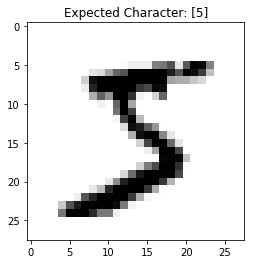

In [22]:
train_images_file = './datasets/train-images-idx3-ubyte'
train_labels_file = './datasets/train-labels-idx1-ubyte'

train_images = import_mnist_images(train_images_file)
train_labels = import_mnist_labels(train_labels_file)

print('Train images matrix shape: ' + str(train_images.shape))
print('Train labels matrix shape: ' + str(train_labels.shape))
display_mnist_image(train_images[0],train_labels[0])

## Importing test files

In [5]:
test_images_file = './datasets/t10k-images-idx3-ubyte'
test_labels_file = './datasets/t10k-labels-idx1-ubyte'

test_images = import_mnist_images(test_images_file)
test_labels = import_mnist_labels(test_labels_file)

print('Test images matrix shape: ' + str(test_images.shape))
print('Test labels matrix shape: ' + str(test_labels.shape))

Test images matrix shape: (10000, 784)
Test labels matrix shape: (10000, 1)


# Training the Convolutional Neural Network

## Data Preprocessing

In [8]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Importing the dataset
X_train = train_images
y_train = train_labels
X_test = test_images
y_test = test_labels

# Encoding categorical data
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
onehotencoder = OneHotEncoder()
y_train = onehotencoder.fit_transform(y_train).toarray()
y_test = onehotencoder.fit_transform(y_test).toarray()

# Splitting the dataset into the Training set and Test set
#from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [9]:
print('Test labels encoding')
for i in range(5):
    print(str(test_labels[i]) + ' ---> ' + str(y_test[i]))    

Test labels encoding
[7] ---> [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
[2] ---> [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
[1] ---> [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
[0] ---> [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[4] ---> [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]


## Now let's make the CNN! (LeNet)

In [15]:
# Importing the Keras libraries and packages
import keras
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense

# Defining constants
input_width  = 28
input_height = 28 
input_depth  = 1

# Initialising the CNN
classifier = Sequential()

# First set of CONV => RELU => POOL
classifier.add(Convolution2D(20, 5, 5, input_shape = (input_width, input_height, input_depth),
                             activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Second set of CONV => RELU => POOL
classifier.add(Convolution2D(50, 5, 5, activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Set of FC => RELU layers
classifier.add(Flatten())
classifier.add(Dense(output_dim = 500, activation = 'relu'))

# Softmax classifier
classifier.add(Dense(output_dim = 10, activation = 'softmax'))

# Compiling the CNN
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Funtion to reshape 784 arrays to 28x28 images
def reshape_to_image(dataset, width, height):
    import numpy as np
    dataset = np.array(dataset)
    dataset = dataset.reshape(dataset.shape[0], width, height)
    return dataset

# reshape the MNIST dataset from a flat list of 784-dim vectors, to
# 28 x 28 pixel images, then scale the data to the range [0, 1.0]
# and construct the training and testing splits
X_train = reshape_to_image(X_train, input_width, input_height)
X_test  = reshape_to_image(X_test, input_width, input_height)

# Adding on extra dimension to dataset, because keras expects
# us to provide at least one dimension, so we do
# (60000, 28, 28) --> (60000, 28, 28, 1)
X_train = X_train[:, :, :, np.newaxis]
X_test  = X_test[:, :, :, np.newaxis]

# Fitting the ANN to the Training set
classifier.fit(X_train, y_train, batch_size = 10, nb_epoch = 10)

/usr/lib/python3/dist-packages/ipykernel_launcher.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(20, (5, 5), input_shape=(28, 28, 1..., activation="relu")`
/usr/lib/python3/dist-packages/ipykernel_launcher.py:23: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(50, (5, 5), activation="relu")`
/usr/lib/python3/dist-packages/ipykernel_launcher.py:28: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=500)`
/usr/lib/python3/dist-packages/ipykernel_launcher.py:31: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=10)`
/usr/local/lib/python3.6/dist-packages/keras/models.py:944: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Epoch 1/10
60000/60000 [==============================] - 106s 2ms/step - loss: 0.0189 - acc: 0.9937
Epoch 2/10
60000/60000 [==============================] - 111s 2ms/step - loss: 0.0094 - acc: 0.9971
Epoch 3/10
60000/60000 [==============================] - 112s 2ms/step - loss: 0.0071 - acc: 0.9979
Epoch 4/10
60000/60000 [==============================] - 122s 2ms/step - loss: 0.0060 - acc: 0.9982
Epoch 5/10
60000/60000 [==============================] - 105s 2ms/step - loss: 0.0056 - acc: 0.9984
Epoch 6/10
60000/60000 [==============================] - 102s 2ms/step - loss: 0.0047 - acc: 0.9988
Epoch 7/10
60000/60000 [==============================] - 104s 2ms/step - loss: 0.0052 - acc: 0.9987
Epoch 8/10
60000/60000 [==============================] - 124s 2ms/step - loss: 0.0055 - acc: 0.9987
Epoch 9/10
60000/60000 [==============================] - 111s 2ms/step - loss: 0.0053 - acc: 0.9989
Epoch 10/10
60000/60000 [==============================] - 113s 2ms/step - loss: 0.0043 - a

## Making the predictions and evaluating the model

In [17]:
def prop_to_category(prob_array):
    "Convert a probability array to a category array, where the bigger prop is the class"
    import numpy as np
    index_max = np.argmax(prob_array)
    categ_array = [0] * len(prob_array) # create array of zeroes
    categ_array[index_max] = 1
    return categ_array

def onehot_to_int(onehot_matrix):
    "Convert a matrix of one-hot arrays to a matrix of int corresponding to the one-hot 1 index"
    import numpy as np
    int_array = [0] * len(onehot_matrix) # create array of zeroes
    for idx, val in enumerate(onehot_matrix):
        index_max = np.argmax(val) # finds the index of the '1'
        int_array[idx] = index_max
    return int_array

# Predicting the Test set results
y_pred = classifier.predict(X_test)
# Finds the predicted category
for idx in range(len(y_pred)):
    y_pred[idx] = prop_to_category(y_pred[idx])
# Converts one-hot array to int
y_pred = onehot_to_int(y_pred)
y_test = onehot_to_int(y_test)

In [18]:
print(y_pred[0:10])
print(y_test[0:10])

[7, 2, 1, 0, 4, 1, 4, 9, 5, 9]
[7, 2, 1, 0, 4, 1, 4, 9, 5, 9]


The accuracy was 98.82%


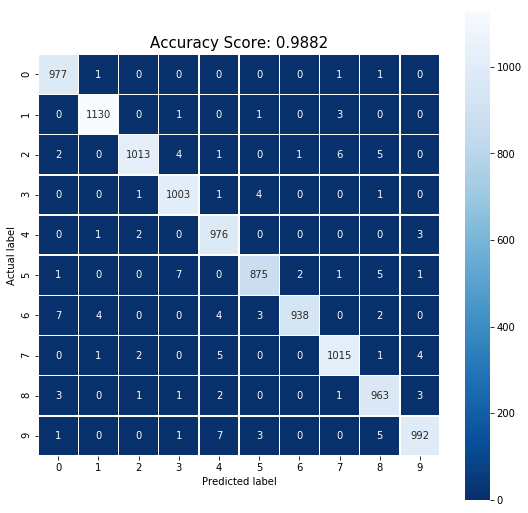

In [23]:
from sklearn.metrics import accuracy_score
score = accuracy_score(y_test, y_pred)
print('The accuracy was %s%%' % (score*100))

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
#print(cm)

import seaborn as sns
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);
plt.show()